In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow import keras
### hack tf-keras to appear as top level keras
import sys
sys.modules['keras'] = keras
### end of hack

import keras.backend as K
from keras.utils import multi_gpu_model
from keras.callbacks import TensorBoard

from sklearn.model_selection import KFold

import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from keras.callbacks import *
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pprint
import os
from os import listdir
from os.path import isfile, join
from datetime import datetime

from sklearn.metrics import confusion_matrix

from keras.utils import plot_model
import matplotlib.pyplot as plt

# Importing custom framework
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
from data_split import prepare_data_spectrogram, return_generators, plot_confusion_matrix

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
def build_cnn():
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [3]:
spectrogramPath = '../../merged/spectrogram.hdf5'
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_spectrogram(spectrogramPath, False)
print(X_train.shape)
X_train = tf.transpose(X_train, [0, 2, 3, 1])
X_val = tf.transpose(X_val, [0, 2, 3, 1])
X_test = tf.transpose(X_test, [0, 2, 3, 1])

(18000, 1, 227, 227)


In [4]:
import gc
gc.collect()
K.clear_session()
tf.compat.v1.reset_default_graph()

In [5]:
tbCallBack = TensorBoard(log_dir='logs', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         write_images=True)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

# Experiment 1

In [6]:
model = build_cnn()
plot_model(model, to_file='CNN_Experiment1.png', show_shapes=True, show_layer_names=True)
opt = SGD(lr=0.001, momentum=0.9, clipvalue=5)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [7]:
K.clear_session()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=32, callbacks=[earlyStopping, tbCallBack], shuffle=False)

val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
  1/563 [..............................] - ETA: 0s - loss: 4.1473 - accuracy: 0.2500WARNING:tensorflow:From /home/carl/anaconda3/envs/xai_model_explanation/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
563/563 [==============================] - 269s 478ms/step - loss: 2.2840 - accuracy: 0.1316 - val_loss: 2.1877 - val_accuracy: 0.2573
Epoch 2/100
563/563 [==============================] - 271s 482ms/step - loss: 1.1551 - accuracy: 0.5861 - val_loss: 0.6258 - val_accuracy: 0.8025
Epoch 3/100
563/563 [==============================] - 270s 480ms/step - loss: 0.3799 - accuracy: 0.8727 - val_loss: 0.4453 - val_accuracy: 0.8683
Epoch 4/100
563/563 [==============================] - 268s 476ms/step - loss: 0.1990 - accuracy: 0.9346 - val_loss: 0.5933 - val_accuracy: 0.8497
Epoch 5/100
5

Epoch 54/100
563/563 [==============================] - 270s 480ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.2506 - val_accuracy: 0.9627
Epoch 55/100
563/563 [==============================] - 270s 480ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.3443 - val_accuracy: 0.9520
Epoch 56/100
563/563 [==============================] - 270s 479ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.2720 - val_accuracy: 0.9618
Epoch 57/100
563/563 [==============================] - 270s 479ms/step - loss: 0.0029 - accuracy: 0.9989 - val_loss: 0.3359 - val_accuracy: 0.9523
Epoch 58/100
563/563 [==============================] - 270s 479ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.2643 - val_accuracy: 0.9637
Epoch 59/100
563/563 [==============================] - 270s 479ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.2815 - val_accuracy: 0.9595
Epoch 60/100
563/563 [==============================] - 269s 478ms/step - loss: 9.9705e-04 - accuracy: 0.9997 - 

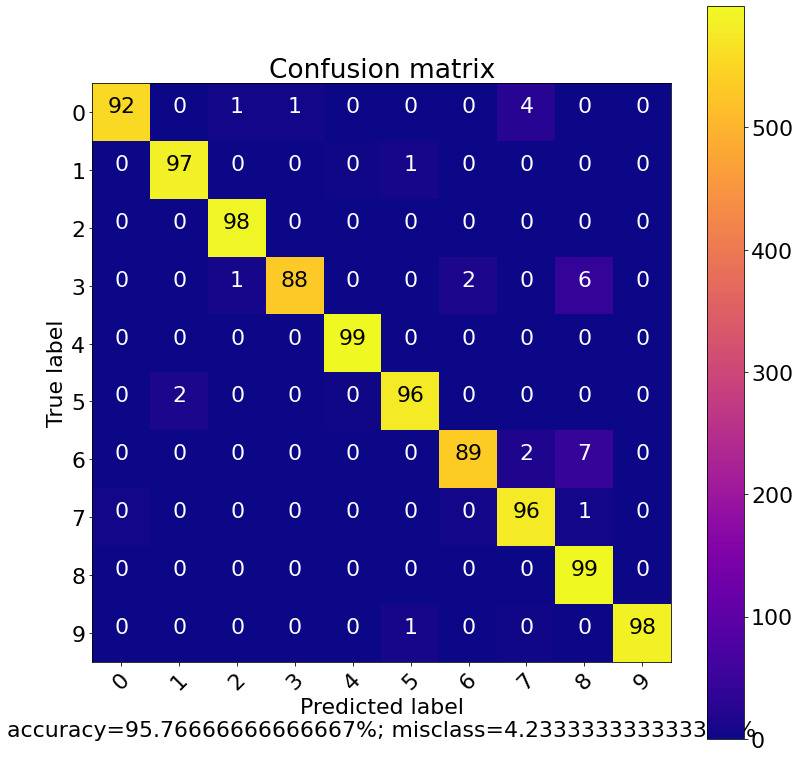

In [8]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [9]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.19307741522789001, 0.9610000252723694]


# Experiment 2

In [10]:
model = build_cnn()
#plot_model(model, to_file='CNN_Experiment2.png', show_shapes=True, show_layer_names=True)
opt = Adam(learning_rate=0.001)

In [11]:
K.clear_session()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=32, callbacks=[earlyStopping, tbCallBack], shuffle=False)

val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
563/563 [==============================] - 266s 473ms/step - loss: 1.7499 - accuracy: 0.4466 - val_loss: 1.4276 - val_accuracy: 0.5000
Epoch 2/100
563/563 [==============================] - 266s 473ms/step - loss: 0.5172 - accuracy: 0.8353 - val_loss: 0.8718 - val_accuracy: 0.7523
Epoch 3/100
563/563 [==============================] - 267s 475ms/step - loss: 0.3002 - accuracy: 0.9076 - val_loss: 1.0319 - val_accuracy: 0.7365
Epoch 4/100
563/563 [==============================] - 268s 475ms/step - loss: 0.2367 - accuracy: 0.9263 - val_loss: 1.0483 - val_accuracy: 0.7550
Epoch 5/100
563/563 [==============================] - 267s 474ms/step - loss: 0.2400 - accuracy: 0.9264 - val_loss: 0.7234 - val_accuracy: 0.8333
Epoch 6/100
563/563 [==============================] - 267s 475ms/step - loss: 0.2000 - accuracy: 0.9421 - val_loss: 0.5566 - val_accuracy: 0.8527
Epoch 7/100
563/563 [==============================] - 268s 475ms/step - loss: 0.1809 - accuracy: 0.9458 - val_loss: 0

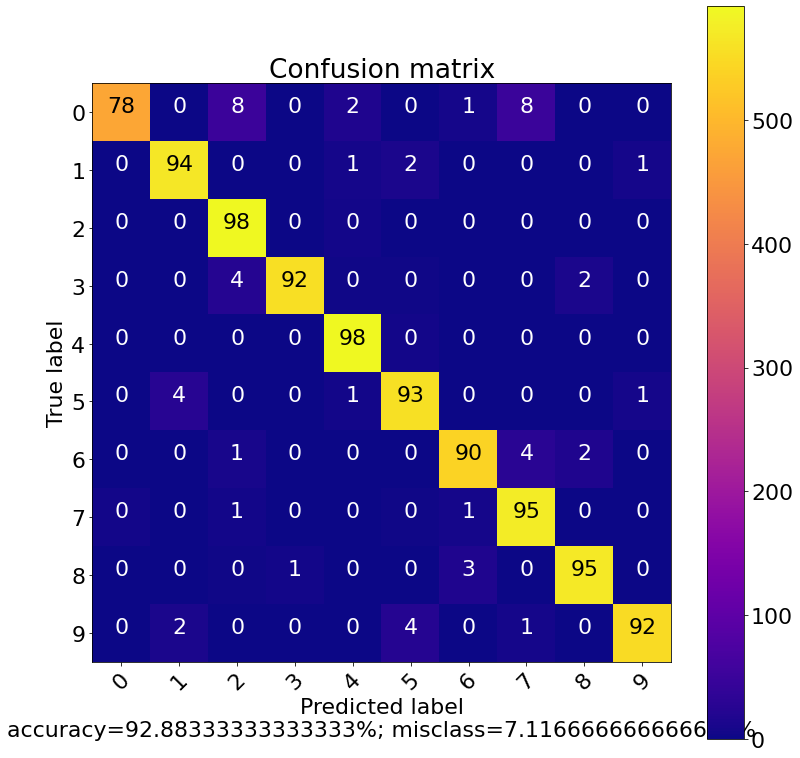

In [12]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [13]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.39936596155166626, 0.9208333492279053]


# Experiment 3

In [14]:
model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)
opt = Adam(learning_rate=0.001)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [15]:
K.clear_session()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=32, callbacks=[earlyStopping, tbCallBack], shuffle=False)

val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
563/563 [==============================] - 198s 351ms/step - loss: 2.3257 - accuracy: 0.0941 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/100
563/563 [==============================] - 198s 351ms/step - loss: 2.3033 - accuracy: 0.0955 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/100
563/563 [==============================] - 197s 351ms/step - loss: 2.3031 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/100
563/563 [==============================] - 197s 350ms/step - loss: 2.3035 - accuracy: 0.0964 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
563/563 [==============================] - 197s 350ms/step - loss: 2.3032 - accuracy: 0.0923 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
563/563 [==============================] - 197s 350ms/step - loss: 2.3030 - accuracy: 0.0966 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
563/563 [==============================] - 197s 350ms/step - loss: 2.3028 - accuracy: 0.0983 - val_loss: 2

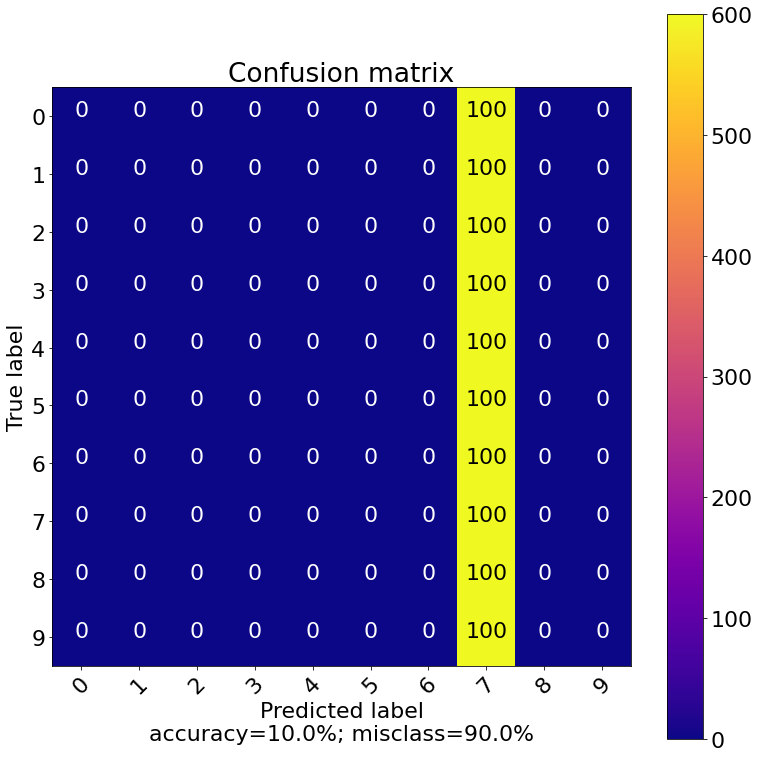

In [16]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [17]:
print(model.evaluate(X_test, y_test, verbose=0))

[2.3025870323181152, 0.10000000149011612]


# Experiment 4

In [18]:
model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
#plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)
opt = Adam(learning_rate=0.01)

In [19]:
K.clear_session()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=32, callbacks=[earlyStopping, tbCallBack], shuffle=False)

val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
563/563 [==============================] - 195s 347ms/step - loss: 5106.9619 - accuracy: 0.1001 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 2/100
563/563 [==============================] - 196s 348ms/step - loss: 2.3054 - accuracy: 0.0941 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/100
563/563 [==============================] - 197s 350ms/step - loss: 2.3042 - accuracy: 0.0886 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/100
563/563 [==============================] - 196s 349ms/step - loss: 2.3081 - accuracy: 0.0925 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
563/563 [==============================] - 197s 349ms/step - loss: 2.3043 - accuracy: 0.0877 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
563/563 [==============================] - 196s 349ms/step - loss: 2.3040 - accuracy: 0.0914 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
563/563 [==============================] - 197s 349ms/step - loss: 2.3042 - accuracy: 0.0874 - val_loss

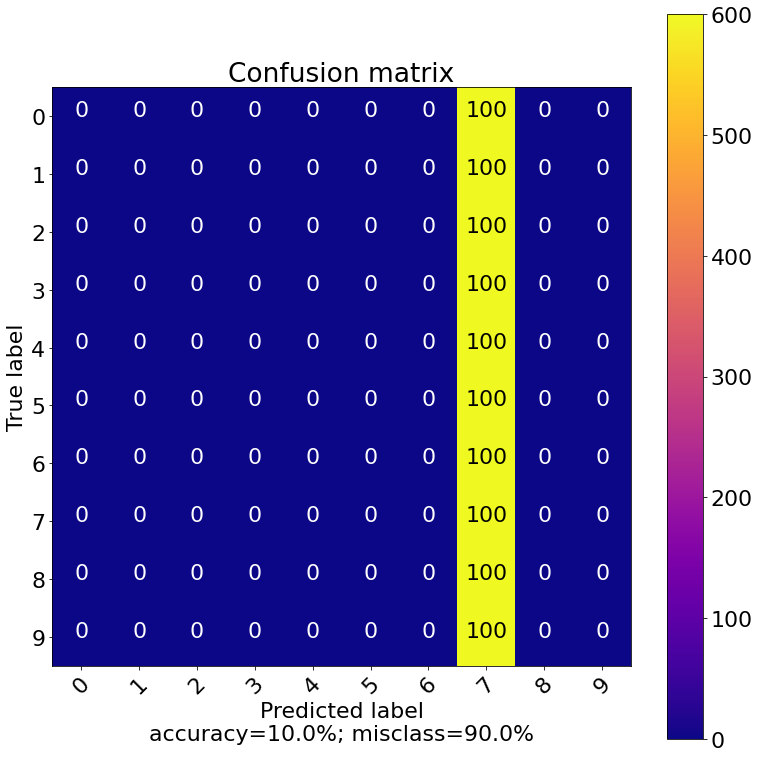

In [20]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [21]:
print(model.evaluate(X_test, y_test, verbose=0))

[2.302612066268921, 0.10000000149011612]


# Experiment 5

In [22]:
model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
#plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)
opt = Adam(learning_rate=0.0001)

In [23]:
K.clear_session()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=32, callbacks=[earlyStopping, tbCallBack], shuffle=False)

val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
563/563 [==============================] - 197s 350ms/step - loss: 1.3389 - accuracy: 0.4870 - val_loss: 0.8042 - val_accuracy: 0.7903
Epoch 2/100
563/563 [==============================] - 197s 351ms/step - loss: 0.1762 - accuracy: 0.9448 - val_loss: 0.4305 - val_accuracy: 0.8832
Epoch 3/100
563/563 [==============================] - 197s 350ms/step - loss: 0.0812 - accuracy: 0.9751 - val_loss: 0.3288 - val_accuracy: 0.9078
Epoch 4/100
563/563 [==============================] - 198s 352ms/step - loss: 0.0562 - accuracy: 0.9841 - val_loss: 0.5497 - val_accuracy: 0.8968
Epoch 5/100
563/563 [==============================] - 198s 351ms/step - loss: 0.0393 - accuracy: 0.9889 - val_loss: 0.3534 - val_accuracy: 0.9115
Epoch 6/100
563/563 [==============================] - 197s 350ms/step - loss: 0.0319 - accuracy: 0.9900 - val_loss: 0.5398 - val_accuracy: 0.9027
Epoch 7/100
563/563 [==============================] - 197s 351ms/step - loss: 0.0270 - accuracy: 0.9917 - val_loss: 0

563/563 [==============================] - 197s 350ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.1423 - val_accuracy: 0.9780
Epoch 57/100
563/563 [==============================] - 197s 350ms/step - loss: 0.0069 - accuracy: 0.9985 - val_loss: 0.2574 - val_accuracy: 0.9712
Epoch 58/100
563/563 [==============================] - 197s 350ms/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 0.1722 - val_accuracy: 0.9772
Epoch 59/100
563/563 [==============================] - 197s 350ms/step - loss: 0.0110 - accuracy: 0.9981 - val_loss: 0.2740 - val_accuracy: 0.9392
Epoch 60/100
563/563 [==============================] - 197s 349ms/step - loss: 0.0079 - accuracy: 0.9977 - val_loss: 0.2577 - val_accuracy: 0.9758
Epoch 61/100
563/563 [==============================] - 197s 351ms/step - loss: 0.0098 - accuracy: 0.9982 - val_loss: 0.2308 - val_accuracy: 0.9763
Epoch 62/100
563/563 [==============================] - 197s 350ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.4114 

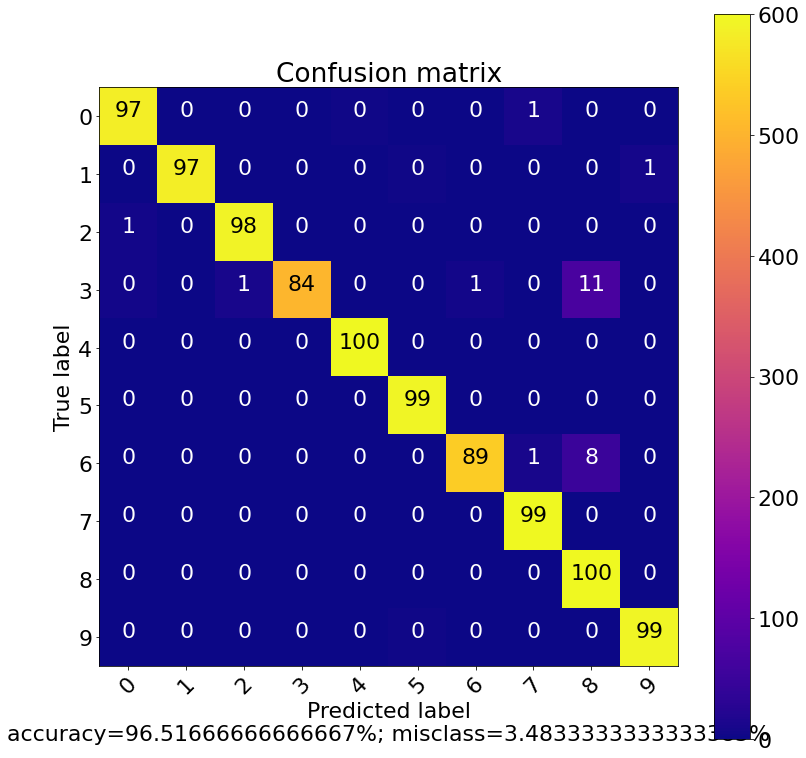

In [24]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [25]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.1615193635225296, 0.9793333411216736]
